# Electricity Power Market playbook

<p>
Mal Minhas, v0.2<br>
19.08.24
</p>
<p>
<h4>Versions</h4>
<ul>
<li><b>v0.1</b>: 18.08.24. First version</li>
<li><b>v0.2</b>: 19.08.24. Added operating profit support</li>
</ul>
</p>

### 1. Introduction

A key principle of any **electricity power market** is to seek to meet demand at the lowest cost. So if demand is low, we only use cheap generators.  With higher demand, one by one the more expensive generators are added.  In this way, the supply function of electricity is created as illustrated below.  On the X axis is the capacity of the power plants, on the Y axis is their variable generation cost.  The supply function is a step function; each step represents the capacity and the variable costs of a power plant.  The way in which the generators are ranked in the supply function, from low to high variable operating costs, is also called the **merit order** of generation.

<div>
<img src="meritOrder.png" width="600"/>
</div>

Power plants have two types of costs:
* **Fixed Costs**: these are the costs you have to pay independent of how much your plant is producing. e.g. capital costs, fixed operating maintenance costs and wages.
* **Variable costs**: these are the costs that are calculated per unit of output.  e.g. costs of the fuel and the costs of the CO2 emissions, if applicable.

You should ONLY consider variable costs when you decide whether to operate the plant because when the price is higher than your variable costs you have a positive net cash flow. This may seem counter-intuitive but whether or not your fixed costs are high are irrelevant to the decision whether or not to run your plant.  You should always run your plant when 
When you have a positive cash flow, this will help to pay off these fixed costs.  Whether this is enough to cover them totally in the long run does not matter now: any positive cashflow from operating your plant is better than none, given that you need to make your fixed cost payments anyway.  A related concept is that of **marginal cost**: this is the cost of producing an additional unit of output.  The marginal cost of a power plant is the cost of producing an additional MWh of electricity.   Sometimes, the terms variable cost and marginal cost are used interchangeably, because for fossil fuel plants they are approximately the same, within the normal operating range of a plant.  Another important concept is **system marginal cost**.  This is the cost of producing one more unit of electricity by the whole market.  It is equal to the variable cost of the most expensive plant that is needed to meet demand.  In other words, the variable cost of the marginal plant.

There is ultimately no certainty that generators will be able to cover their fixed costs: there is investment risk.  If generators do not recover their costs, they will stop investing. Over time, as plants get older and are taken out of service, this leads to scarcity.  Then the market price goes up and investors recover their costs again.

For more detail on merit order and marginal pricing see [this article](https://www.squeaky.energy/blog/understanding-power-markets-merit-order-and-marginal-pricing).

### 2. Power Plant model with Carbon Pricing

Consider a hypothetical electricity market with five power plants: a nuclear power plant, an offshore wind farm, a coal plant, a coal plant with CCS (carbon capture and sequestration) and a natural gas plant defined as follows where the four values for each plant in the list are: plant name, fuel costs in Euro/MWh, $CO_2$ emissions in ton/MWh and Capacity in MW.  Taken together, the fuel costs and $CO_2$ emissions constitute the **variable costs** on a per hour basis:

In [1]:
power_plants = [
    ["Nuclear Power Plant", 20, 0, 1000],
    ["Wind Farm", 0, 0, 800],
    ["Coal Plant", 18, 0.9, 1000],
    ["Coal Plant with CCS", 22, 0.1, 600],
    ["Natural Gas Plant", 40, 0.46, 500],
]

We can now construct a `pandas` dataframe as follows to have a look at this market:

In [2]:
import pandas as pd

cols = ['Plant','Fuel Costs (Euro/MWh)','CO2 emissions [ton/MWh]','Capacity [MW]']
df = pd.DataFrame(power_plants, columns=cols)
df

,Plant,Fuel Costs (Euro/MWh),CO2 emissions [ton/MWh],Capacity [MW]
0,Nuclear Power Plant,20,0.00,1000
1,Wind Farm,0,0.00,800
2,Coal Plant,18,0.90,1000
3,Coal Plant with CCS,22,0.10,600
4,Natural Gas Plant,40,0.46,500


In the context of this maket, baseload low demand is 1200MW and high demand is 2900MW. 

Let's create a model of the merit order for this market and allow for $CO_2$ pricing to be applied.  In this scenario, the merit order will be determined by two variables only - the `demand` and the `co2_price`.  A function called `graph_merit_order` will draw a bar chart of the merit order.  The colour of the bars roughly reflects the degree of $CO_2$ emissions:

In [3]:
class PowerPlant:
    def __init__(self, name, fuel_cost, co2_emissions, capacity):
        self.name = name
        self.fuel_cost = fuel_cost
        self.co2_emissions = co2_emissions
        self.capacity = capacity

    def total_cost(self, co2_price):
        return round(self.fuel_cost + (self.co2_emissions * co2_price), 2)

def calculate_merit_order(power_plants, demand, co2_price):
    # Define plants
    plants = []
    for plant in power_plants:
        plants.append(PowerPlant(*plant))

    # Calculate the total cost for each plant
    for plant in plants:
        plant.cost = plant.total_cost(co2_price)

    # Sort the plants by total cost (merit order)
    plants_sorted = sorted(plants, key=lambda p: p.cost)

    # Create the merit order list
    merit_order = []
    total_capacity = 0

    for plant in plants_sorted:
        if total_capacity >= demand:
            break
        merit_order.append((plant.name, plant.cost, min(plant.capacity, demand - total_capacity)))
        total_capacity += plant.capacity

    return merit_order

def display_merit_order(merit_order):
    # Display the merit order
    print("--------------------------- Merit Order: ---------------------------")
    for i,plant in enumerate(merit_order):
        print(f"{i+1}. {plant[0]}, Cost: {plant[1]:.2f} Euro/MWh, Capacity Used: {plant[2]} MW")
    print("--------------------------------------------------------------------")
    
def graph_merit_order(merit_order, demand, co2_price, extra_title=''):
    # 1. pull out the data we need and create dataframe
    x = [x[2] for x in merit_order]       # x-axis is the demand => each 2nd element
    y = [x[1] for x in merit_order]       # y-axis is the price => each 1st element
    labels = [x[0] for x in merit_order]  # label is the name of plant so every 0th element
    # 2. Define an offset to extend bars below zero
    offset = 0  # You can adjust this value as needed
    y_with_offset = [value - offset for value in y]
    dfm = pd.DataFrame({'Plant': labels, 'Demand (MW)': x, 'Price (Euro/MWh)': y_with_offset})
    # 3. Assign colors to bars based on the plant names
    color_mapping = {
        'Nuclear Power Plant': 'mediumseagreen',
        'Wind Farm': 'green',
        'Solar Farm': 'green',
        'Coal Plant': 'black',
        'Coal Plant with CCS': 'lightgrey',
        'Natural Gas Plant' : 'dimgrey',
        'Interconnect' : 'silver',
        # Add more mappings as needed
    }
    colors = dfm['Plant'].map(color_mapping)
    # 4. plot the data and set graph title
    ax = dfm.plot(kind='bar', x='Demand (MW)', y='Price (Euro/MWh)', color=colors, figsize=(15, 4), legend=False)
    ax.set_title(f'Merit Order of Power Plants at demand={demand}MW and CO2 price=€{co2_price}{extra_title}')
    ax.set_ylabel('Price (Euro/MWh)')
    # 5. Rotate the x-axis labels for better readability
    ax.set_xticklabels(dfm['Demand (MW)'], rotation=0)
    # 6. Add a grid
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)  # Grid on y-axis with dashed lines
    # 7. Annotate each bar with the name of the plant (above the bar)
    for i in range(len(dfm)):
        ax.text(i, y[i] + 0.1, f"{dfm['Plant'][i]} (€{dfm['Price (Euro/MWh)'][i]}/MWh)", ha='center', va='bottom', fontsize=10)
    # 8. Calculate the highest point plus a margin for the y-axis limit
    max_y = max(y)
    ax.set_ylim(0, max_y + 1.5)  # Adjust the limit as needed
    # 9. Set the y-axis to start below the minimum value in y_with_offset
    #ax.set_ylim(min(y_with_offset) - 1, max(y_with_offset) + 1.5)  # Adjust the limits as needed
    # 10. Remove the black border top and right
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)

Let's display and then graph the merit order for a low demand scenario when there is no $CO_2$ price.  In this scenario we set `demand` to 1200 and `co2_price` to 0:

--------------------------- Merit Order: ---------------------------
1. Wind Farm, Cost: 0.00 Euro/MWh, Capacity Used: 800 MW
2. Coal Plant, Cost: 18.00 Euro/MWh, Capacity Used: 400 MW
--------------------------------------------------------------------


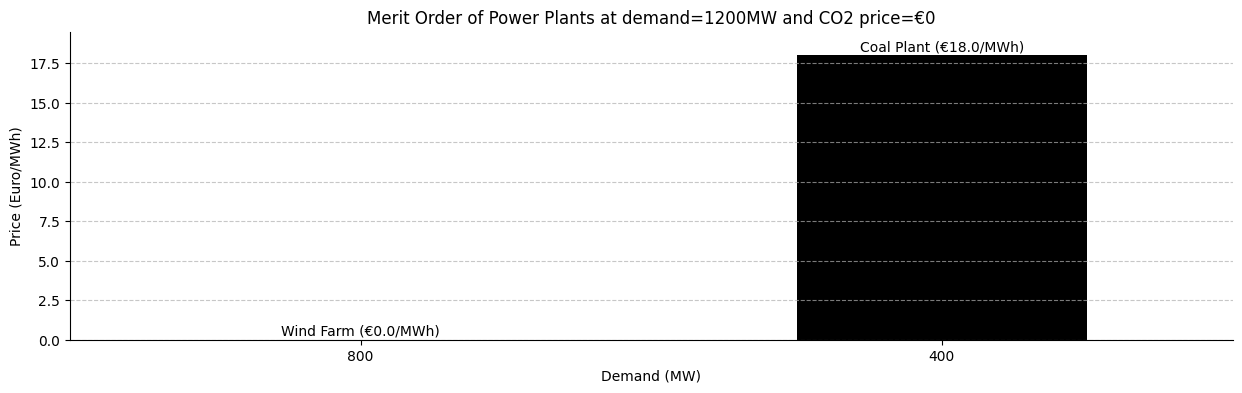

In [4]:
demand = 1200  # MW
co2_price = 0  # Euro/ton
merit_order = calculate_merit_order(power_plants, demand, co2_price)
display_merit_order(merit_order)
graph_merit_order(merit_order, demand, co2_price)

Now let's display and graph the merit order for a high demand scenario when there is no $CO_2$ price.  In this scenario we set `demand` to 2900 and `co2_price` to 0:

--------------------------- Merit Order: ---------------------------
1. Wind Farm, Cost: 0.00 Euro/MWh, Capacity Used: 800 MW
2. Coal Plant, Cost: 18.00 Euro/MWh, Capacity Used: 1000 MW
3. Nuclear Power Plant, Cost: 20.00 Euro/MWh, Capacity Used: 1000 MW
4. Coal Plant with CCS, Cost: 22.00 Euro/MWh, Capacity Used: 100 MW
--------------------------------------------------------------------


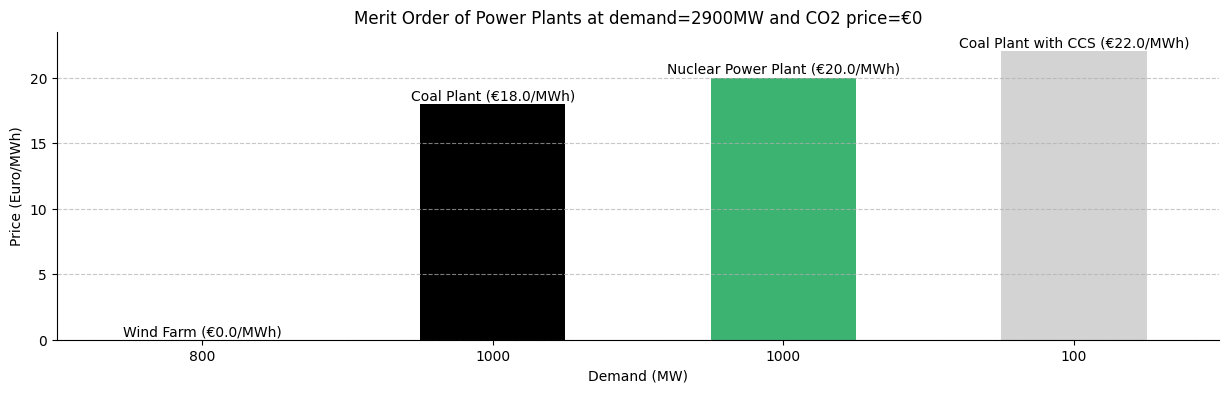

In [5]:
demand = 2900  # MW
co2_price = 0  # Euro/ton
merit_order = calculate_merit_order(power_plants, demand, co2_price)
display_merit_order(merit_order)
graph_merit_order(merit_order, demand, co2_price)

Let's add in a price of €10/ton of $CO_2$ and see if it changes the merit order:

--------------------------- Merit Order: ---------------------------
1. Wind Farm, Cost: 0.00 Euro/MWh, Capacity Used: 800 MW
2. Nuclear Power Plant, Cost: 20.00 Euro/MWh, Capacity Used: 1000 MW
3. Coal Plant with CCS, Cost: 23.00 Euro/MWh, Capacity Used: 600 MW
4. Coal Plant, Cost: 27.00 Euro/MWh, Capacity Used: 500 MW
--------------------------------------------------------------------


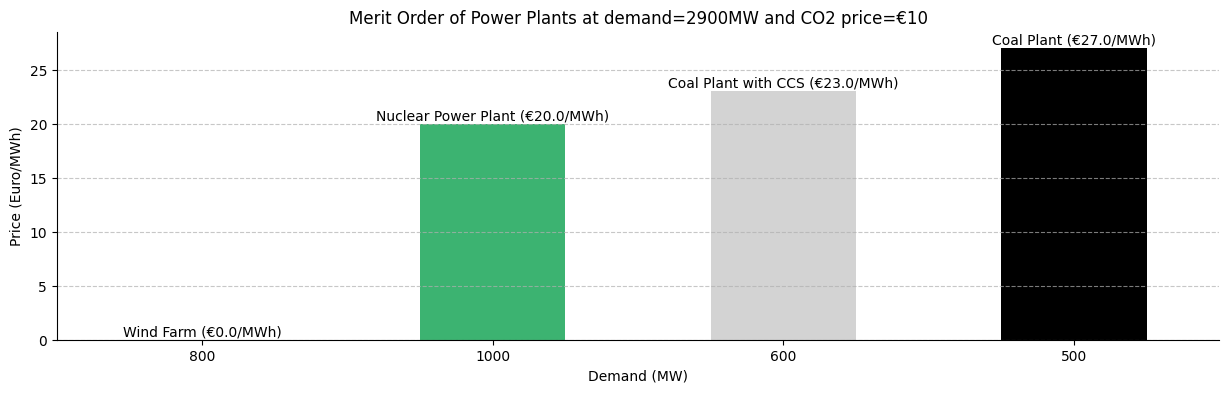

In [6]:
demand = 2900  # MW
co2_price = 10  # Euro/ton
merit_order = calculate_merit_order(power_plants, demand, co2_price)
display_merit_order(merit_order)
graph_merit_order(merit_order, demand, co2_price)

Indeed it does.  We see that pricing in the cost of carbon at €10/ton means that the coal plant drops to the end of the merit order.  What if we continue to increase the price of $CO_2$?

--------------------------- Merit Order: ---------------------------
1. Wind Farm, Cost: 0.00 Euro/MWh, Capacity Used: 800 MW
2. Nuclear Power Plant, Cost: 20.00 Euro/MWh, Capacity Used: 1000 MW
3. Coal Plant with CCS, Cost: 27.10 Euro/MWh, Capacity Used: 600 MW
4. Natural Gas Plant, Cost: 63.46 Euro/MWh, Capacity Used: 500 MW
--------------------------------------------------------------------


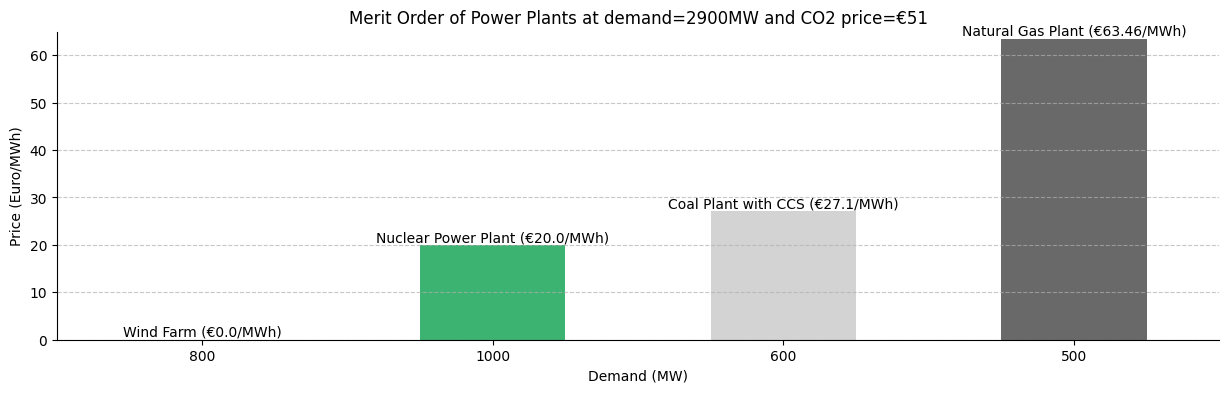

In [7]:
demand = 2900  # MW
co2_price = 51  # Euro/ton
merit_order = calculate_merit_order(power_plants, demand, co2_price)
display_merit_order(merit_order)
graph_merit_order(merit_order, demand, co2_price)

We see that at a €51/ton, coal is supplanted by the Natural Gas Plant in the merit order.  At €50/ton, the coal plant remains in the merit order.  This is more [broadly reflective of the current UK electricity generation mix](https://grid.iamkate.com/) illustrated below.  However, it should be noted that $CO_2$ price in the UK [has declined to £40/ton](https://www.statista.com/statistics/1322275/carbon-prices-united-kingdom-emission-trading-scheme/) from a peak of over £100/ton two years ago.  £40/ton is approx €47/ton which is close to the switchover point in this example.

<div>
<img src="electricitySourceMix.png" width="900"/>
</div>

### 3. Power plant with variable wind output

Consider a hypothetical electricity market with the following profile for nuclear, wind, coal, coal with CCS and natural gas:

In [8]:
power_plants = [
    ["Nuclear Power Plant", 20, 0, 300],
    ["Wind Farm", 0, 0, 1000],
    ["Coal Plant", 10, 0.9, 400],
    ["Coal Plant with CCS", 25, 0.1, 500],
    ["Natural Gas Plant", 45, 0.46, 1000],
]

Now let's calculate the merit order for a low demand scenario of 1300MW:

--------------------------- Merit Order: ---------------------------
1. Wind Farm, Cost: 0.00 Euro/MWh, Capacity Used: 1000 MW
2. Coal Plant, Cost: 10.00 Euro/MWh, Capacity Used: 300 MW
--------------------------------------------------------------------


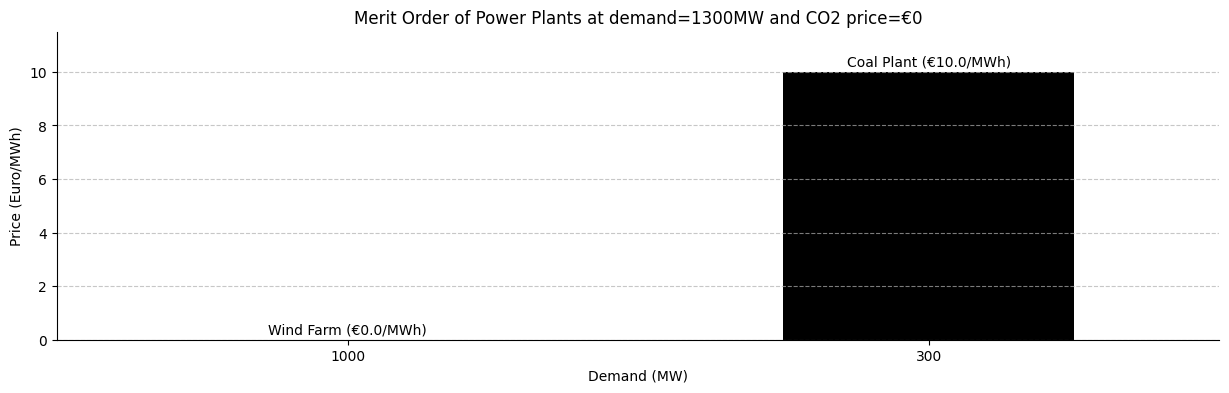

In [9]:
demand = 1300  # MW
co2_price = 0  # Euro/ton
merit_order = calculate_merit_order(power_plants, demand, co2_price)
display_merit_order(merit_order)
graph_merit_order(merit_order, demand, co2_price)

We have ended up with coal in the merit order because variable costs for coal are really low in this electricity market and no prices has been set to accommodate the impact of carbon emissions.  What happens if we hike up the carbon price?

--------------------------- Merit Order: ---------------------------
1. Wind Farm, Cost: 0.00 Euro/MWh, Capacity Used: 1000 MW
2. Nuclear Power Plant, Cost: 20.00 Euro/MWh, Capacity Used: 300 MW
--------------------------------------------------------------------


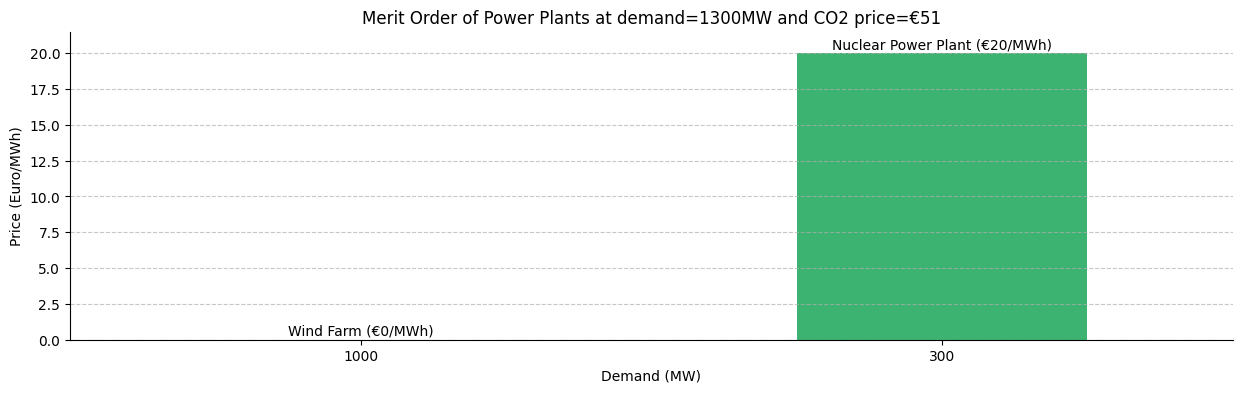

In [10]:
demand = 1300  # MW
co2_price = 51  # Euro/ton
merit_order = calculate_merit_order(power_plants, demand, co2_price)
display_merit_order(merit_order)
graph_merit_order(merit_order, demand, co2_price)

We get a more real world outcome in terms of $CO_2$ emissions in this scenario with nuclear favoured over coal.  

A key issue with wind is its variability.  On a still day, capacity may drop to just 3% of peak capacity.  Let's model what happens in our toy electricity market as a result:

--------------------------- Merit Order: ---------------------------
1. Wind Farm, Cost: 0.00 Euro/MWh, Capacity Used: 30.0 MW
2. Nuclear Power Plant, Cost: 20.00 Euro/MWh, Capacity Used: 300 MW
3. Coal Plant with CCS, Cost: 30.10 Euro/MWh, Capacity Used: 500 MW
4. Coal Plant, Cost: 55.90 Euro/MWh, Capacity Used: 400 MW
5. Natural Gas Plant, Cost: 68.46 Euro/MWh, Capacity Used: 70.0 MW
--------------------------------------------------------------------


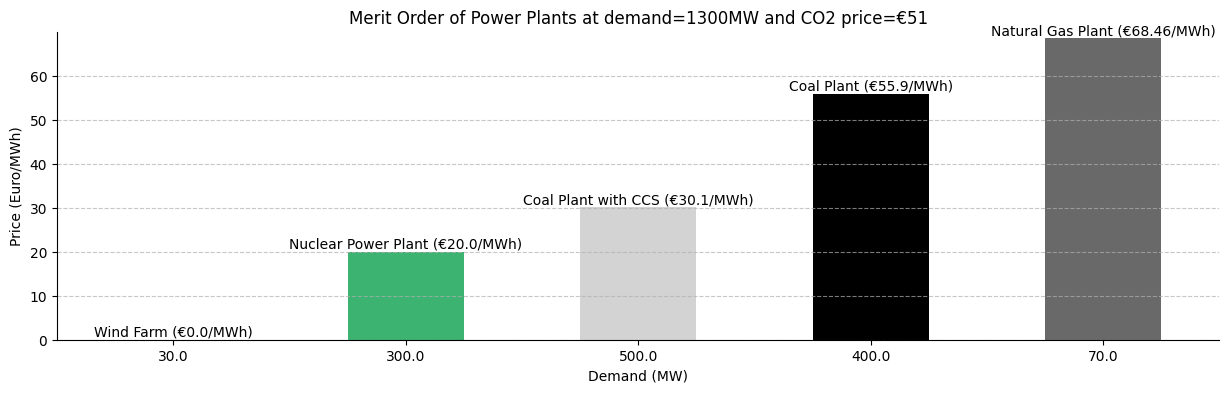

In [11]:
wind_factor = 0.03
power_plants = [
    ["Nuclear Power Plant", 20, 0, 300],
    ["Wind Farm", 0, 0, 1000 * wind_factor],
    ["Coal Plant", 10, 0.9, 400],
    ["Coal Plant with CCS", 25, 0.1, 500],
    ["Natural Gas Plant", 45, 0.46, 1000],
]

demand = 1300  # MW
co2_price = 51  # Euro/ton
merit_order = calculate_merit_order(power_plants, demand, co2_price)
display_merit_order(merit_order)
graph_merit_order(merit_order, demand, co2_price)

We see all generators in this market now active in the merit order and the marginal price of electricity pushed up from €20/MWh to €68.46/MWh as a result of low wind!   Now suppose the government has instituted policies that make it attractive to built out solar farms in this market.  As a result, a 300MW solar farm has gone online.  This should be able to push out the need for natural gas and most of the coal plant power even on a low wind day helping to reduce the marginal cost of electricity to €55.9/MWh:

--------------------------- Merit Order: ---------------------------
1. Wind Farm, Cost: 0.00 Euro/MWh, Capacity Used: 30.0 MW
2. Solar Farm, Cost: 0.00 Euro/MWh, Capacity Used: 300 MW
3. Nuclear Power Plant, Cost: 20.00 Euro/MWh, Capacity Used: 300 MW
4. Coal Plant with CCS, Cost: 30.10 Euro/MWh, Capacity Used: 500 MW
5. Coal Plant, Cost: 55.90 Euro/MWh, Capacity Used: 170.0 MW
--------------------------------------------------------------------


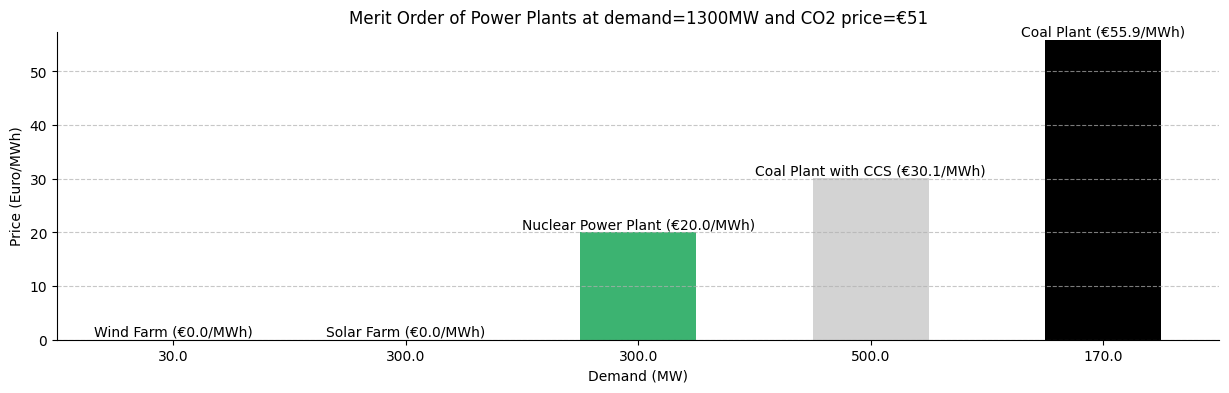

In [12]:
low_wind_factor = 0.03
power_plants = [
    ["Nuclear Power Plant", 20, 0, 300],
    ["Wind Farm", 0, 0, 1000 * low_wind_factor],
    ["Solar Farm", 0, 0, 300],
    ["Coal Plant", 10, 0.9, 400],
    ["Coal Plant with CCS", 25, 0.1, 500],
    ["Natural Gas Plant", 45, 0.46, 1000],
]

demand = 1300  # MW
co2_price = 51  # Euro/ton
merit_order = calculate_merit_order(power_plants, demand, co2_price)
display_merit_order(merit_order)
graph_merit_order(merit_order, demand, co2_price)

What if demand goes up to 2900MWh as a result of a cold snap and a major sporting event being watched by most of the population?  We see in this case that   

--------------------------- Merit Order: ---------------------------
1. Wind Farm, Cost: 0.00 Euro/MWh, Capacity Used: 30.0 MW
2. Solar Farm, Cost: 0.00 Euro/MWh, Capacity Used: 300 MW
3. Nuclear Power Plant, Cost: 20.00 Euro/MWh, Capacity Used: 300 MW
4. Coal Plant with CCS, Cost: 30.10 Euro/MWh, Capacity Used: 500 MW
5. Coal Plant, Cost: 55.90 Euro/MWh, Capacity Used: 400 MW
6. Interconnect, Cost: 63.26 Euro/MWh, Capacity Used: 1370.0 MW
--------------------------------------------------------------------


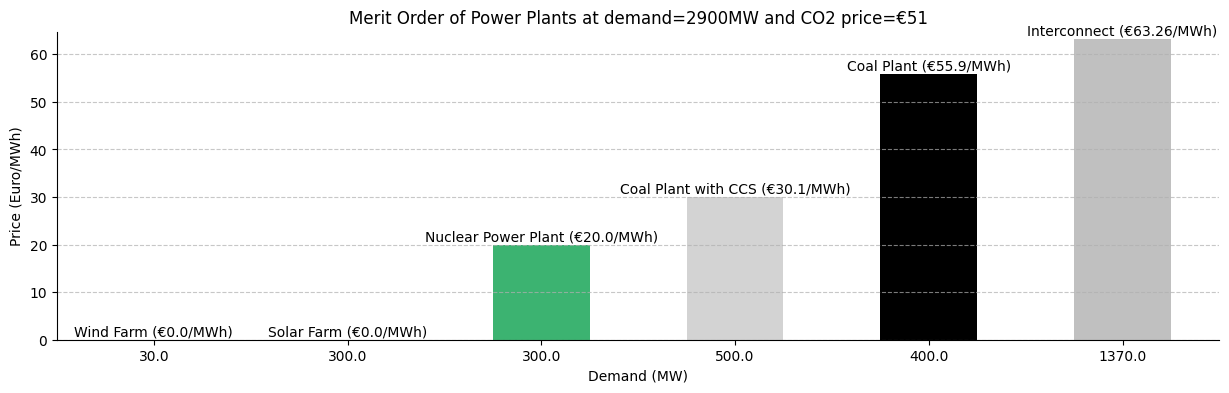

In [13]:
low_wind_factor = 0.03
power_plants = [
    ["Nuclear Power Plant", 20, 0, 300],
    ["Wind Farm", 0, 0, 1000 * low_wind_factor],
    ["Solar Farm", 0, 0, 300],
    ["Coal Plant", 10, 0.9, 400],
    ["Coal Plant with CCS", 25, 0.1, 500],
    ["Natural Gas Plant", 45, 0.46, 1000],
    ["Interconnect", 50, 0.26, 2000],
]

demand = 2900  # MW
co2_price = 51  # Euro/ton
merit_order = calculate_merit_order(power_plants, demand, co2_price)
display_merit_order(merit_order)
graph_merit_order(merit_order, demand, co2_price)

### 4. Operating profits for generators

Add support to calculate the 

In [14]:
class PowerPlant:
    def __init__(self, name, fuel_cost, co2_emissions, capacity):
        self.name = name
        self.fuel_cost = fuel_cost
        self.co2_emissions = co2_emissions
        self.capacity = capacity

    def total_cost(self, co2_price):
        return round(self.fuel_cost + (self.co2_emissions * co2_price), 2)

    def operating_profit(self, electricity_price, co2_price):
        cost = self.total_cost(co2_price)
        revenue = electricity_price  # revenue per MWh
        profit = round((revenue - cost) * self.capacity, 2)  # profit for total capacity
        #print(f"Hourly profit for '{self.name}' for {self.capacity}MW, revenue={revenue}, costs={cost} = {profit}")
        return profit

def calculate_marginal_price(merit_order):
    prices = [x[1] for x in merit_order]
    return max(prices)
  
def calculate_operating_profits(power_plants, electricity_price, co2_price):
    # Define plants
    plants = []
    for plant in power_plants:
        plants.append(PowerPlant(*plant))

    # Calculate the operating profit for each plant
    operating_profits = []
    for plant in plants:
        profit = plant.operating_profit(electricity_price, co2_price)
        operating_profits.append((plant.name, profit))

    return operating_profits

power_plants = [
    ["Nuclear Power Plant", 20, 0, 1000],
    ["Wind Farm", 0, 0, 800],
    ["Coal Plant", 18, 0.9, 1000],
    ["Coal Plant with CCS", 22, 0.1, 600],
    ["Natural Gas Plant", 40, 0.46, 500],
]


demand = 1300  # MW
co2_price = 51  # Euro/ton
merit_order = calculate_merit_order(power_plants, demand, co2_price)
display_merit_order(merit_order)
electricity_price = calculate_marginal_price(merit_order)
print(f"Electricity price = €{electricity_price}/MWh")

operating_profits = calculate_operating_profits(power_plants, electricity_price, co2_price)
active_plants = [x[0] for x in merit_order]
print("-------------- Operating Profits in merit order: -------------------")
for plant in operating_profits:
    if plant[0] in active_plants:
        print(f"{plant[0]}, Operating Profit per hour: €{plant[1]}")
print("--------------------------------------------------------------------")

--------------------------- Merit Order: ---------------------------
1. Wind Farm, Cost: 0.00 Euro/MWh, Capacity Used: 800 MW
2. Nuclear Power Plant, Cost: 20.00 Euro/MWh, Capacity Used: 500 MW
--------------------------------------------------------------------
Electricity price = €20/MWh
-------------- Operating Profits in merit order: -------------------
Nuclear Power Plant, Operating Profit per hour: €0
Wind Farm, Operating Profit per hour: €16000
--------------------------------------------------------------------


What are the operating profits across the merit order in a low wind scenario?

In [15]:
low_wind_factor = 0.03
power_plants = [
    ["Nuclear Power Plant", 20, 0, 300],
    ["Wind Farm", 0, 0, 1000 * low_wind_factor],
    ["Coal Plant", 10, 0.9, 400],
    ["Coal Plant with CCS", 25, 0.1, 500],
    ["Natural Gas Plant", 45, 0.46, 1000],
]

demand = 1300  # MW
co2_price = 51  # Euro/ton
merit_order = calculate_merit_order(power_plants, demand, co2_price)
display_merit_order(merit_order)
electricity_price = calculate_marginal_price(merit_order)
print(f"Electricity price = €{electricity_price}/MWh")

operating_profits = calculate_operating_profits(power_plants, electricity_price, co2_price)
active_plants = [x[0] for x in merit_order]
print("-------------- Operating Profits in merit order: -------------------")
for plant in operating_profits:
    if plant[0] in active_plants:
        print(f"{plant[0]}, Operating Profit per hour: €{plant[1]}")
print("--------------------------------------------------------------------")

--------------------------- Merit Order: ---------------------------
1. Wind Farm, Cost: 0.00 Euro/MWh, Capacity Used: 30.0 MW
2. Nuclear Power Plant, Cost: 20.00 Euro/MWh, Capacity Used: 300 MW
3. Coal Plant with CCS, Cost: 30.10 Euro/MWh, Capacity Used: 500 MW
4. Coal Plant, Cost: 55.90 Euro/MWh, Capacity Used: 400 MW
5. Natural Gas Plant, Cost: 68.46 Euro/MWh, Capacity Used: 70.0 MW
--------------------------------------------------------------------
Electricity price = €68.46/MWh
-------------- Operating Profits in merit order: -------------------
Nuclear Power Plant, Operating Profit per hour: €14538.0
Wind Farm, Operating Profit per hour: €2053.8
Coal Plant, Operating Profit per hour: €5024.0
Coal Plant with CCS, Operating Profit per hour: €19180.0
Natural Gas Plant, Operating Profit per hour: €0.0
--------------------------------------------------------------------
